Upload screw-only images first...


Saving 20240713_193907.jpg to 20240713_193907 (4).jpg
Saving 20240713_193831.jpg to 20240713_193831 (4).jpg
Saving 20240713_194200.jpg to 20240713_194200 (4).jpg
Saving img1.jpg to img1 (4).jpg
Saving img1_43_nosy.jpg to img1_43_nosy (4).jpg
Saving img2.jpg to img2 (4).jpg
Upload bolt-only images next...


Saving 20240713_194606.jpg to 20240713_194606 (6).jpg
Saving 20240713_194621.jpg to 20240713_194621 (5).jpg
Saving 20240713_194630.jpg to 20240713_194630 (5).jpg

=== Model Evaluation ===
Accuracy: 0.9781420765027322

Classification Report:
              precision    recall  f1-score   support

       Screw       0.97      0.99      0.98       104
        Bolt       0.99      0.96      0.97        79

    accuracy                           0.98       183
   macro avg       0.98      0.98      0.98       183
weighted avg       0.98      0.98      0.98       183

Confusion Matrix:
 [[103   1]
 [  3  76]]
Now upload test images (containing screws or bolts)...


Saving 20240713_193839.jpg to 20240713_193839 (4).jpg
Saving 20240713_192951.jpg to 20240713_192951 (4).jpg
Saving 20240713_193135.jpg to 20240713_193135 (4).jpg
Saving 20240713_193650.jpg to 20240713_193650 (4).jpg
Saving 20240713_194206.jpg to 20240713_194206 (4).jpg
Saving 20240713_194215.jpg to 20240713_194215 (4).jpg
Saving 20240713_194232.jpg to 20240713_194232 (4).jpg
Saving 20240713_194256.jpg to 20240713_194256 (4).jpg
Saving 20240713_194316.jpg to 20240713_194316 (4).jpg
Saving 20240713_194541.jpg to 20240713_194541 (4).jpg
Saving 20240713_194551.jpg to 20240713_194551 (4).jpg
Saving 20240713_193659.jpg to 20240713_193659 (4).jpg
20240713_193839 (4).jpg -> Screws: 197, Bolts: 1


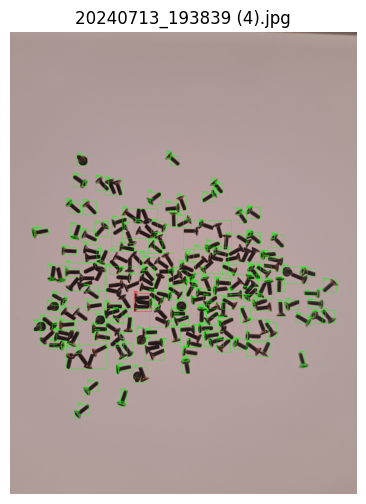

20240713_192951 (4).jpg -> Screws: 44, Bolts: 0


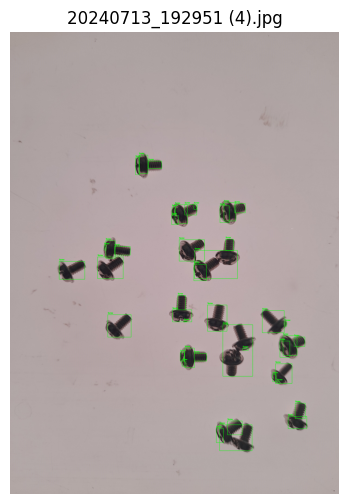

20240713_193135 (4).jpg -> Screws: 38, Bolts: 0


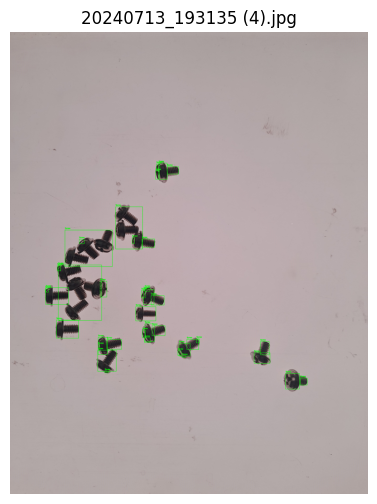

20240713_193650 (4).jpg -> Screws: 6, Bolts: 0


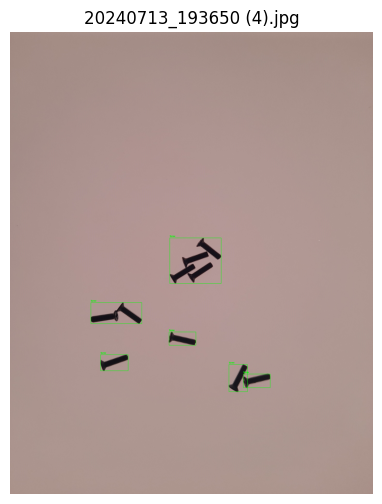

20240713_194206 (4).jpg -> Screws: 87, Bolts: 3


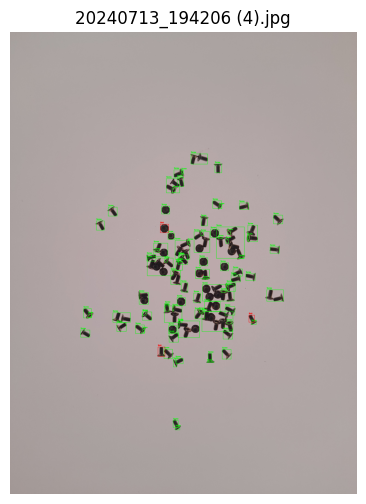

20240713_194215 (4).jpg -> Screws: 101, Bolts: 0


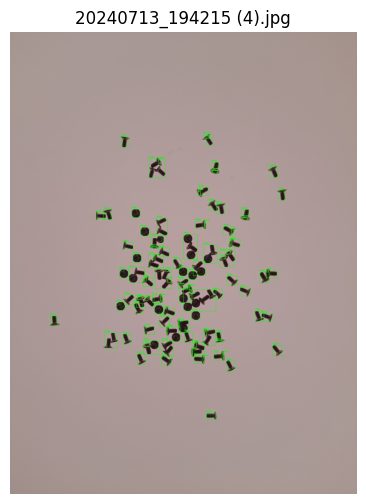

20240713_194232 (4).jpg -> Screws: 112, Bolts: 2


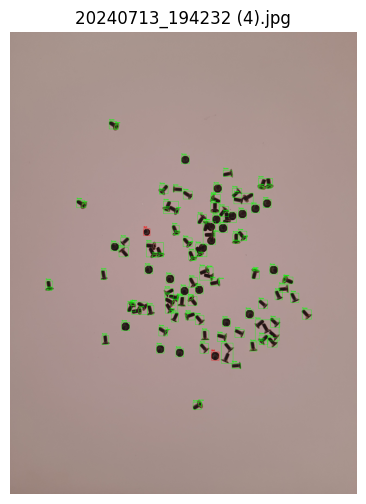

20240713_194256 (4).jpg -> Screws: 103, Bolts: 1


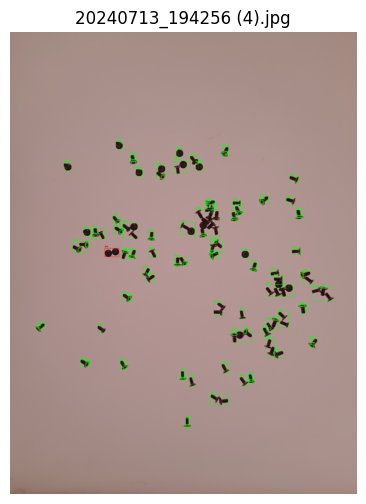

20240713_194316 (4).jpg -> Screws: 122, Bolts: 3


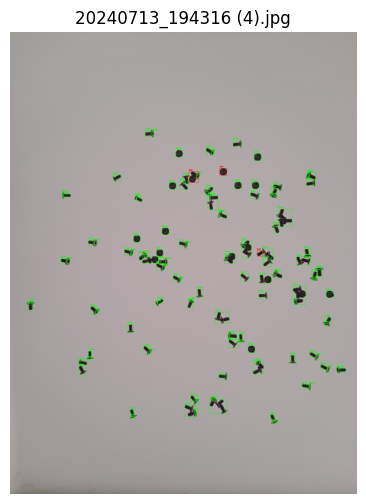

20240713_194541 (4).jpg -> Screws: 0, Bolts: 49


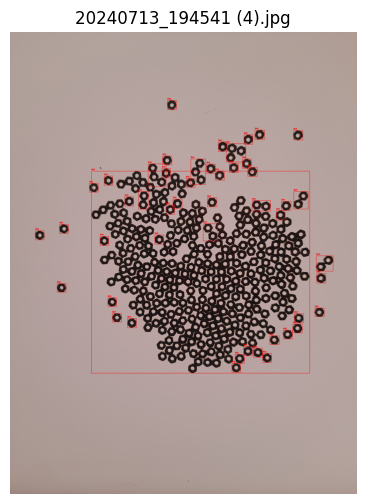

20240713_194551 (4).jpg -> Screws: 2, Bolts: 51


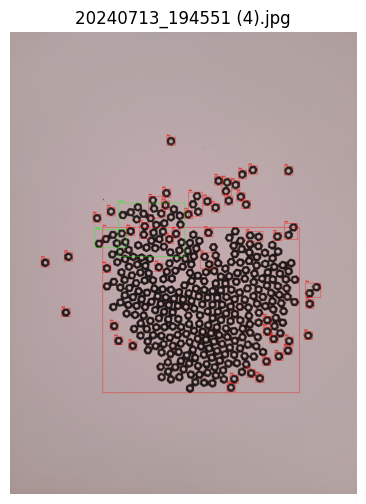

20240713_193659 (4).jpg -> Screws: 8, Bolts: 2


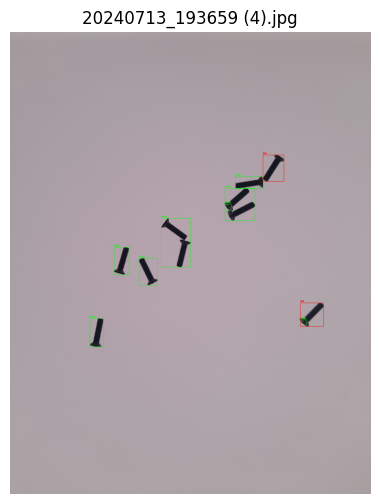

In [ ]:
from google.colab import files
import cv2
import numpy as np
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt


def extract_features_from_contour(contour, image):
    x, y, w, h = cv2.boundingRect(contour)
    roi = image[y:y+h, x:x+w]
    roi_gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)

    hu_moments = cv2.HuMoments(cv2.moments(roi_gray)).flatten()
    aspect_ratio = float(w) / h
    area = cv2.contourArea(contour)
    rect_area = w * h
    extent = float(area) / rect_area if rect_area != 0 else 0
    hull = cv2.convexHull(contour)
    hull_area = cv2.contourArea(hull)
    solidity = float(area) / hull_area if hull_area != 0 else 0

    return np.hstack([hu_moments, aspect_ratio, extent, solidity])

# Load labeled images (label: 0=screw, 1=bolt)
def load_labeled_features(label):
    uploaded = files.upload()
    features = []
    labels = []
    for fname in uploaded:
        image = cv2.imread(fname)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        blurred = cv2.GaussianBlur(gray, (5, 5), 0)
        thresh = cv2.threshold(blurred, 60, 255, cv2.THRESH_BINARY_INV)[1]
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        for contour in contours:
            if cv2.contourArea(contour) > 100:
                feat = extract_features_from_contour(contour, image)
                features.append(feat)
                labels.append(label)
    return features, labels

# Train the classifier
def train_model(features, labels):
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

    model.fit(X_train_scaled, y_train)


    X_test_scaled = scaler.transform(X_test)
    y_pred = model.predict(X_test_scaled)

    print("\n=== Model Evaluation ===")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=["Screw", "Bolt"]))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

    return model, scaler



def predict_on_mixed_images(model, scaler):
    print("Now upload test images (containing screws or bolts)...")
    uploaded = files.upload()
    for fname in uploaded:
        image = cv2.imread(fname)
        draw = image.copy()
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        blurred = cv2.GaussianBlur(gray, (5, 5), 0)
        thresh = cv2.threshold(blurred, 60, 255, cv2.THRESH_BINARY_INV)[1]
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        screw_count = 0
        bolt_count = 0
        for contour in contours:
            if cv2.contourArea(contour) > 100:
                feat = extract_features_from_contour(contour, image)
                feat_scaled = scaler.transform([feat])
                pred = model.predict(feat_scaled)[0]

                x, y, w, h = cv2.boundingRect(contour)
                if pred == 0:
                    label = "Screw"
                    color = (0, 255, 0)
                    screw_count += 1
                else:
                    label = "Bolt"
                    color = (0, 0, 255)
                    bolt_count += 1

                cv2.rectangle(draw, (x, y), (x+w, y+h), color, 2)
                cv2.putText(draw, label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

        print(f"{fname} -> Screws: {screw_count}, Bolts: {bolt_count}")
        plt.figure(figsize=(10, 6))
        plt.imshow(cv2.cvtColor(draw, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title(fname)
        plt.show()


def run_full_pipeline():
    print("Upload screw-only images first...")
    screw_features, screw_labels = load_labeled_features(label=0)

    print("Upload bolt-only images next...")
    bolt_features, bolt_labels = load_labeled_features(label=1)

    all_features = screw_features + bolt_features
    all_labels = screw_labels + bolt_labels

    model, scaler = train_model(all_features, all_labels)
    predict_on_mixed_images(model, scaler)

run_full_pipeline()
